### Python package voor een FewsPI service

Voorbeeld notebook om vanuit Python te praten met een openbare of lokale FewsPi service.

Allereerst, importeer de module als volgt:

In [2]:
from hkvfewspy.io.fewspi import pi

De volgende functies zijn beschikbaar via de module
- setClient
- getFilters
- getParameters
- getTimeSeries
- getTimeZoneID

Om een pi service uit te lezen moet deze eerst als client gezet worden. Dit kan met de functie `setClient`. Een wsdl service URL moet ingevuld worden en dat is bijvoorbeeld `http://localhost:8081/FewsPiService/fewspiservice?wsdl` of `http://localhost:8101/FewsPiService?wsdl`

In [3]:
pi.setClient(wsdl = 'http://localhost:8081/FewsPiService/fewspiservice?wsdl')

Vervolgens kan je filters uitlezen welke binnen de service bekend zijn. Wanneer de client bekend is heeft deze functie verder geen parameters nodig

In [4]:
filters = pi.getFilters()
vars(filters)

{'f_fewsPi': {'description': '', 'id': 'f_fewsPi', 'name': 'Fews-Pi service'},
 'f_trend_1': {'description': '', 'id': 'f_trend.1', 'name': 'Cut-data'},
 'f_trend_2': {'description': '', 'id': 'f_trend.2', 'name': 'Fill-data'},
 'f_werk_1': {'description': '',
  'id': 'f_werk.1',
  'name': 'Baggeren + Zandwinning + Agiteren (/baggervak)'},
 'f_werk_2': {'description': '',
  'id': 'f_werk.2',
  'name': 'Verspreiden (/verspreidingsvak)'}}

De filters worden als attributen onder het filters object gehangen op basis van het filter id onder `pi.Filters`, waarbij vreemde karaketers (zoals een `.`) worden omgezet in `_`

In [5]:
filters.f_werk_1

{'description': '',
 'id': 'f_werk.1',
 'name': 'Baggeren + Zandwinning + Agiteren (/baggervak)'}

Een uitgelezen filter welke als attribute is toegevoegd kan gebruikt worden als `filterId`.

In [6]:
filterId = pi.Filters.f_werk_1['id']
print (filterId)

f_werk.1


Vervolgens kunnen de locties voor de desbetreffende filter uitgelezen worden met de `getLocations` functie. Met `setFormat` kan het formaat worden bepaald hoe het object teruggegeven moet worden. Dit kan zijn:
- `gdf` voor een GeoDataFrame formaat
- `geojson` voor een GeoJSON formaat
- `dict` voor een Dictionary formaat

(De verschillende formaten worden momenteel allemaal ook als attributes bijgeschreven onder het `pi.Locations` object)

In [7]:
gdf = pi.getLocations(filterId = filterId,
                      setFormat = 'gdf')

Met een GeoDataFrame formaat kan je het gelijk visualiseren of -gewoon- als DataFrame vervolg acties op doen

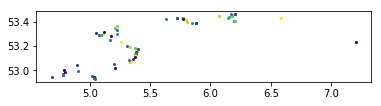

In [8]:
%matplotlib inline
gdf.plot()

In [9]:
gdf.head()

,locationId,shortName,x,y,geometry
bv_1_7_1_1,bv.1.7.1.1,"Den Helder - Texel, Vaarweg",114887.0,555232.0,POINT (4.789939580471975 52.98258358193483)
bv_1_7_1_1_1_1,bv.1.7.1.1.1.1,"Den Helder veerhaven, Vak A",114278.0,553377.0,POINT (4.781104282194812 52.96586925822925)
bv_1_7_1_1_1_2,bv.1.7.1.1.1.2,"Den Helder veerhaven, Vak B",114113.0,553202.0,POINT (4.778670536487695 52.96428425924832)
bv_1_7_1_1_1_3,bv.1.7.1.1.1.3,"Den Helder veerhaven, Vak C",114243.0,553255.0,POINT (4.780598637222577 52.96477034363196)
bv_1_7_1_1_2_1,bv.1.7.1.1.2.1,"Texel veerhaven, Vak A",114395.0,557589.0,POINT (4.782320076077784 53.00372620992813)


Om een `list` te krijgen van alle beschikbare locaties doe het volgende. Er wordt vervolgens alleen de eerste 5 items getoond

In [10]:
locationIds = gdf.locationId.tolist()
locationIds[0:5]

['bv.1.7.1.1',
 'bv.1.7.1.1.1.1',
 'bv.1.7.1.1.1.2',
 'bv.1.7.1.1.1.3',
 'bv.1.7.1.1.2.1']

Zoals gezegd worden de verschillende formaten als attributes onder het `pi.Locations` object weggeschreven, waarbij het GeoJSON formaat gelijk binnen een mapping module zoals `folium` gebruikt kan worden:

In [11]:
# import folium
# mapa = folium.Map([53.2, 5.5],
#                   zoom_start=9,
#                   tiles='cartodbpositron')

# geoJSONdata = pi.Locations.asGeoJSON
# points = folium.features.GeoJson(pi.Locations.asGeoJSON)

# mapa.add_children(points)
# mapa

Om ook popups te linken aan folium is het makkelijker om vanuit een GeoDataFrame te werken en niet via een GeoJSON bestand

In [12]:
import folium
mapa = folium.Map([53.2, 5.5],
                  zoom_start=9,
                  tiles='cartodbpositron')

fg=folium.FeatureGroup(name="locations")
for idx, row in gdf.iterrows():
    fg.add_child(folium.Marker(location=[row['geometry'].y, row['geometry'].x],
                              popup=(folium.Popup('NAAM: '+row['shortName']+" ID: "+row['locationId'])))) 
mapa.add_child(fg)
mapa.add_child(folium.LayerControl())
mapa

Of maak gebruik van de geojsonio module om het te parsen naar een site als www.geojson.io inclusief opmaak van tooltips

In [13]:
#import geojsonio
#geojsonio.embed(pi.Locations.asGeoJSON) # dit is niet embed, maar doet een redirect naar de website. Save notebook eerst.

Net zoals de locaties kunnen worden uitgelezen voor een filter is dat ook zo voor de parameters. Dit kan met de `getParameters` functie:

In [14]:
params = pi.getParameters(filterId=filterId)
vars(params)

{'k_m3_geagiteerd_vdlee': {'displayUnit': 'm3',
  'id': 'k.m3.geagiteerd.vdlee',
  'name': 'Kuubs geagiteerd (m3 - dagrapport)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'},
 'k_m3_gebaggerd_mars': {'displayUnit': 'm3',
  'id': 'k.m3.gebaggerd.mars',
  'name': 'Kuubs gebaggerd (m3 - mars)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'},
 'k_m3_gebaggerd_vdlee': {'displayUnit': 'm3',
  'id': 'k.m3.gebaggerd.vdlee',
  'name': 'Kuubs gebaggerd (m3 - dagrapport)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'},
 'k_m3_zandwinning_vdlee': {'displayUnit': 'm3',
  'id': 'k.m3.zandwinning.vdlee',
  'name': 'Kuubs zand winning (m3 - dagrapport)',
  'parameterType': 'instantaneous',
  'unit': 'm3',
  'usesDatum': 'true'}}

Ook deze worden als attribute onder het object opgeslagen.

In [15]:
parameterIds = pi.Parameters.k_m3_geagiteerd_vdlee['id']
parameterIds

'k.m3.geagiteerd.vdlee'

Voor de `getTimeSeries` functie zijn ook nog de start en eindtijd nodig om de periode te bepalen voor de data request. Dit kan met een `datetime` object.

In [16]:
from datetime import datetime
startTime = datetime(2017,3,1)
endTime =  datetime.now()

In dit geval zijn de startTime en endTime niet bewust van een timezone. In dit geval worden deze intern alsnog bepaald op basis `clientTimeZone` parameter. Standaard staat deze op `Europe/Amsterdam`. Mogelijke timezones worden bepaald met de pytz module (`import pytz`, `pytz.all_timezones`). 

Er worden items terug gegeven. Eerst het data object zelf in het gewenste `format`. En daarnaast nog een `entry`, wat op dit moment een combinatie is van `parameterId|locationId|units`. Deze `entry` zou bijvoorbeeld gebruikt kunnen worden als `key` voor een entry in de hkv.services dataportal 

Zoals gezegd zijn er meerdere formats, welke met `setFormat` ingesteld kan worden. Keuze kan gemaakt worden uit:
- `df` voor pandas DataFrame
- `json` voor een JSON formatted output
- `gzip` voor een GZIP gecomprimiteerde JSON string

In [17]:
df, entry = pi.getTimeSeries(filterId = filterId,
                             parameterIds = parameterIds, 
                             locationIds=locationIds, 
                             startTime=startTime, 
                             endTime=endTime, 
                             clientTimeZone='Europe/Amsterdam',
                             setFormat='df')
print (entry)

k.m3.geagiteerd.vdlee|bv.1.7.2.1.1.B|m3


In [23]:
df.head()

,date,moduleId,parameterId,units,locationId,stationName,flag,value
0,2017-03-01 00:00:00+01:00,pr.Reizen.vdLee.baggeracties,k.m3.geagiteerd.vdlee,m3,bv.1.7.1.1,"Den Helder - Texel, Vaarweg",8.0,NaN
1,2017-03-01 00:00:00+01:00,pr.Reizen.vdLee.baggeracties,k.m3.geagiteerd.vdlee,m3,bv.1.7.1.1.1.1,"Den Helder veerhaven, Vak A",8.0,NaN
2,2017-03-01 00:00:00+01:00,pr.Reizen.vdLee.baggeracties,k.m3.geagiteerd.vdlee,m3,bv.1.7.1.1.1.2,"Den Helder veerhaven, Vak B",8.0,NaN
3,2017-03-01 00:00:00+01:00,pr.Reizen.vdLee.baggeracties,k.m3.geagiteerd.vdlee,m3,bv.1.7.1.1.1.3,"Den Helder veerhaven, Vak C",8.0,NaN
4,2017-03-01 00:00:00+01:00,pr.Reizen.vdLee.baggeracties,k.m3.geagiteerd.vdlee,m3,bv.1.7.1.1.2.1,"Texel veerhaven, Vak A",8.0,NaN


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [20]:
df.reset_index(inplace=True)
df['value'].replace(-999.0,np.NaN, inplace = True)

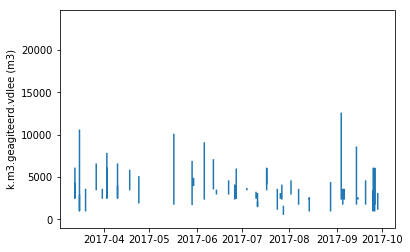

In [21]:
fig, ax = plt.subplots()
ax.plot(df['date'],df['value'],'-')
ylabel = df['parameterId'][0] + ' ('+df['units'][0]+')'
ax.set_ylabel(ylabel)
plt.show()

Ondanks dat het formaat DataFrame was opgegeven kan een JSON formatted output opgevraagd worden via het attribute onder de TimeSeries object. 

Kijk uit met opvragen van de gehele string sinds deze groot kan zijn.

In [22]:
pi.TimeSeries.asJSON[0:1000]

'[{"date":"2017-02-28T23:00:00.000Z","moduleId":"pr.Reizen.vdLee.baggeracties","parameterId":"k.m3.geagiteerd.vdlee","units":"m3","locationId":"bv.1.7.1.1","stationName":"Den Helder - Texel, Vaarweg","flag":8.0,"value":-999.0},{"date":"2017-02-28T23:00:00.000Z","moduleId":"pr.Reizen.vdLee.baggeracties","parameterId":"k.m3.geagiteerd.vdlee","units":"m3","locationId":"bv.1.7.1.1.1.1","stationName":"Den Helder veerhaven, Vak A","flag":8.0,"value":-999.0},{"date":"2017-02-28T23:00:00.000Z","moduleId":"pr.Reizen.vdLee.baggeracties","parameterId":"k.m3.geagiteerd.vdlee","units":"m3","locationId":"bv.1.7.1.1.1.2","stationName":"Den Helder veerhaven, Vak B","flag":8.0,"value":-999.0},{"date":"2017-02-28T23:00:00.000Z","moduleId":"pr.Reizen.vdLee.baggeracties","parameterId":"k.m3.geagiteerd.vdlee","units":"m3","locationId":"bv.1.7.1.1.1.3","stationName":"Den Helder veerhaven, Vak C","flag":8.0,"value":-999.0},{"date":"2017-02-28T23:00:00.000Z","moduleId":"pr.Reizen.vdLee.baggeracties","paramete